<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**MODELOS DE PROGRAMACION: MODELO ADIABATICO** -
Prof: Carmen Pellicer Lostao

# CSP - Constraint Satisfiability Problems

## Intro

D-Wave quantum computer is also well suited to solving optimization problems with binary variables that satisfy a condition (SAT problems). But real-world optimization problems often come with **constraints**: conditions of the problem that any valid solution must satisfy.

For example, when optimizing a traveling salesperson’s route through a series of cities, you need a constraint forcing the salesperson to be in exactly one city at each stage of the trip: a solution that puts the salesperson in two or more places at once is invalid.

Quantum samplers such us the [DWaveSampler](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#id15) optimize objective functions that represent problems in formats that are unconstrained (e.g., QUBOs, or unconstrained binary optimization problems). Any constraints in the original problem are represented as part of the objective function; this technique is known as **penalty models**.

Some Leap quantum-classical hybrid solvers accept only unconstrained objective functions; for example, [Hybrid BQM solvers](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#leaphybridsampler). For those too any constraints must be added to the objective function, typically as a penalty. However, some Leap hybrid solvers can handle constraints natively.

Additionally [Hybrid CQM solvers](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#leaphybridcqmsampler) can accept objective functions and constrains. With these solvers there is no need to build penalty functions


In [1]:
# ------ Import necessary packages ----
import networkx as nx
from collections import defaultdict
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import math

## Graph Partitioning

### The Graph Partitioning problem

We explore the **graph partitioning problem**. This is an interesting problem from graph theory with a wide variety of applications. 

For example, suppose that we have a group of people that we need to **split into two equal-sized teams minimally connected between them**. Between some pairs of people there is a friendly relationship. We want to have as few friends on opposite teams as possible. How can we solve this problem?

One way to solve this problem is with the graph partitioning problem. If we think of our group of people as a graph (a node/vertex for each person), and draw an edge between people that are friends, we have a model of our network. If we look for a minimum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as few edges as possible between the groups. In our group of people, this means that we have two teams with as few friends as possible on different teams.

The answer that we are looking for is a partition of the nodes in the graph $G(V,E)$, so we will assign a binary variable for each node, i.e. variable $x_i$ denotes whether node i is in one subset (call it Subset 0) or the other (Subset 1).

#### Objective Function

The objective function that we want should minimize the number of cut edges. To
count how many cut edges we have given a partition of the nodes (assignment of
our binary variables), we start with a single edge.

The table below shows how we count the cut edges for a given graph partition (assignment of values to our
binary variables). Columns $x_i$ and $x_j$ are two nodes; column edge (i, j)
represents an edge between these two nodes.  We only want to **count an edge if
the endpoints are in different subsets**, and so we assign a 1 for the edge column
in this case and a 0 otherwise.

| $x_i$ | $x_j$ | edge (i,j) |
| :---: | :---: | :---: |
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

From this table, we see that we can use the expression $x_i+x_j-2x_ix_j$
to calculate the edge column in our table.  Now for our entire graph, our
objective function can be written as shown below, where the sum is over all
edges in the graph, denoted by E.

$\sum_{(i,j)\in E} (x_i+x_j-2x_ix_j)$

#### Constraint

Next we need to consider our constraint:  **Subset 0 and Subset 1 must have the
same sizes**.

We can measure the size of Subset 1 by summing up our binary
variables.  To ensure the two subsets have the same size, we enforce a
constraint that **Subset 1 has size equal to half of all nodes in the graph**.  We
first consider how to represent this constraint mathematically using our chosen
binary variables, and use the following equality to represent our constraint,
where $V$ represents the set of all nodes in the graph $G(V,E)$.

$\sum_{i \in V} x_i= \frac {|V|}{2}$

For a QUBO, we need our constraints to be represented by mathematical
expressions that are satisfied at their minimum value.  For this constraint, we
can use the following expression that has a minimum value of 0 that occurs when
Subset 1 has size exactly $\frac{|V|}{2}$.

$(\sum_{i \in V} x_i -\frac {|V|}{2})^2 = \sum_{i \in V} x_i^2 + \sum_{i \in V} \sum_{j>i} 2 x_i x_j - |V| \sum_{i \in V} x_i + \frac {|V|^2}{4}$

Next we can simplify this expression down to linear and quadratic terms for our
QUBO.  Recall that for binary variables we can replace any squared term with a
linear term (since 0^2=0 and 1^2=1), and we can remove any constant terms in
our QUBO.  This results in the following final expression for our constraint.

$\sum_{i \in V} (1-|V|)x_i + \sum_{i \in V} \sum_{j>i} 2 x_i x_j$

#### QUBO Function

To combine our objective and constraints into a single QUBO expression, we simply add together the objective function and our constraint (multiplied by $\gamma$, **the Lagrange parameter**)

$\sum_{(i,j)\in E} (x_i+x_j-2x_ix_j) + \gamma (\sum_{i \in V} (1-|V|)x_i + \sum_{i \in V} \sum_{j>i} 2 x_i x_j)$

### Building the BQM

We will run the demo to find the best way of splitting a 40-node graph (an Erdos-Renyi random graph that probabilistically creates an edge between 20% of its node pairs) into two subsets to minimize the number of cut edges.

Graph on 40 nodes created with 155 out of 780.0 possible edges.


None

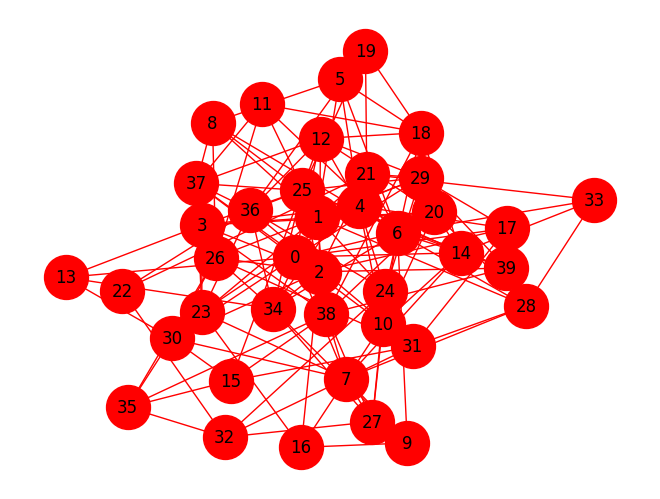

In [3]:
# ------- Set up our graph -------
G = nx.gnp_random_graph(40, 0.2)

print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), len(G.edges), len(G.nodes) * (len(G.nodes)-1) / 2))

display(nx.draw(G,with_labels=True, node_size=1000, node_color='red', edge_color='red'))

Now create the Q matrix for this QUBO as a dictionary iteratively, looping over the edges and nodes in our graph just as we see in the summation of our QUBO expression.

This demo generates an Erdos-Renyi random graph using the networkx package for our problem instance [1]. For more information on this graph generator, see the NetworkX documentation. There are three parameters to be set by the user in this code: chain strength, number of reads, and gamma. Since this is a relatively large problem, we set a large number of reads (num_reads = 1000).

For chain strength, we examine the entries in our Q matrix and choose a relatively large number to enforce chains in our embedding. For this problem, our largest matrix entries are the linear coefficients (approximately size gamma*(1-1*len(G.nodes))) and so a value of gamma*len(G.nodes) is chosen on line 51 for chain_strength.

For gamma, our Lagrange parameter, a good number to start with is an estimate for your optimal objective function value. Since we are utilizing Erdos-Renyi random graphs, we assume that our graph will have about 20% of the number of cut edges that a complete graph would have (since our edge probability in G is also 20%). Since a complete graph on 40 nodes has 780 edges, and any partition into equal subsets results in a cut of size 400 (20 nodes in each subset with all 20x20 edges between subsets cut), we can estimate our objective function value. We are examining an Erdos-Renyi random graph with an edge probability of 20%, we can estimate a cut of size approximately 20% of 400, or 80 edges. This leads us to try a Lagrange parameter of 80, which is implemented in our program with gamma=80.

In [4]:
# ------- Set tunable parameters -------
gamma = 80

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Fill in Q matrix
for u, v in G.edges:
    Q[(u,u)] += 1
    Q[(v,v)] += 1
    Q[(u,v)] += -2

for i in G.nodes:
    Q[(i,i)] += gamma*(1-len(G.nodes))

for i, j in combinations(G.nodes, 2):
	Q[(i,j)] += 2*gamma

### Solving the BQM in the QPU

In [5]:
# ------- Set tunable parameters -------
num_reads = 1000

In [6]:
# ------- Run our QUBO on the QPU -------

# Set chain strength
chain_strength = gamma*len(G.nodes)

# Run the QUBO on the solver
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,
                               chain_strength=chain_strength,
                               num_reads=num_reads,
                               label='Graph Partitioning -DWaveSampler')
print(response)

     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 39   energy num_oc. ...
0    1  0  1  1  1  0  0  1  0  1  1  1  1  1  1  0 ...  0 -31935.0       1 ...
1    1  1  1  1  0  0  1  0  0  0  1  1  1  0  1  0 ...  0 -31934.0       1 ...
2    0  1  0  1  1  0  1  0  1  0  1  0  1  0  1  1 ...  0 -31933.0       1 ...
3    1  1  0  0  1  1  1  0  0  0  1  1  0  1  0  1 ...  0 -31932.0       1 ...
4    1  1  1  1  1  0  0  0  0  1  0  0  1  1  0  1 ...  0 -31931.0       1 ...
5    1  1  1  1  0  0  0  0  0  1  0  0  0  1  0  0 ...  1 -31931.0       1 ...
6    0  1  0  1  0  0  0  1  0  1  1  0  1  0  1  0 ...  0 -31931.0       1 ...
7    1  0  1  0  0  1  1  0  0  0  0  1  1  0  0  1 ...  1 -31931.0       1 ...
8    1  0  1  1  0  0  1  1  0  1  0  0  0  0  1  1 ...  0 -31931.0       1 ...
9    0  0  0  0  1  0  0  0  0  0  0  0  1  0  1  1 ...  0 -31930.0       1 ...
10   1  1  1  0  1  0  1  0  1  1  0  0  1  0  0  1 ...  0 -31929.0       1 ...
11   1  0  0  0  0  1  0  1  0  1  1  0 

In [7]:
df=response.to_pandas_dataframe()
display(df.head(20))
df.to_excel('results_part_graph.xlsx')

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,chain_break_fraction,energy,num_occurrences
0,1,0,1,1,1,0,0,1,0,1,...,1,0,0,0,1,0,0,0.0,-31935.0,1
1,1,1,1,1,0,0,1,0,0,0,...,0,1,0,0,1,1,0,0.0,-31934.0,1
2,0,1,0,1,1,0,1,0,1,0,...,1,0,1,0,1,0,0,0.0,-31933.0,1
3,1,1,0,0,1,1,1,0,0,0,...,1,1,1,1,0,0,0,0.0,-31932.0,1
4,1,1,1,1,1,0,0,0,0,1,...,1,1,1,0,0,0,0,0.0,-31931.0,1
5,1,1,1,1,0,0,0,0,0,1,...,1,1,1,0,0,1,1,0.0,-31931.0,1
6,0,1,0,1,0,0,0,1,0,1,...,0,0,0,1,1,0,0,0.0,-31931.0,1
7,1,0,1,0,0,1,1,0,0,0,...,1,0,0,0,1,0,1,0.0,-31931.0,1
8,1,0,1,1,0,0,1,1,0,1,...,0,0,1,0,1,1,0,0.0,-31931.0,1
9,0,0,0,0,1,0,0,0,0,0,...,0,1,1,1,0,1,0,0.0,-31930.0,1


Printed to the command line that states whether or not the best (lowest energy) solution found is a valid partition that splits the graph into two sets of 20 nodes. If the solution is valid (feasible), then the number of cut edges for that solution is displayed.

In [8]:
# See if the best solution found is feasible, and if so print the number of cut edges.
sample = response.record.sample[0]
print(sample)

# In the case when n is odd, the set may have one more or one fewer nodes
if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
    num_cut_edges = 0
    for u, v in G.edges:
        num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
    print("Valid partition found with", num_cut_edges, "cut edges.")
else:
    print("Invalid partition.")

[1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0
 1 0 0]
Valid partition found with 65 cut edges.


We draw the graph using some [drawing functions](https://networkx.org/documentation/stable/reference/drawing.html) in NetworkX library

None

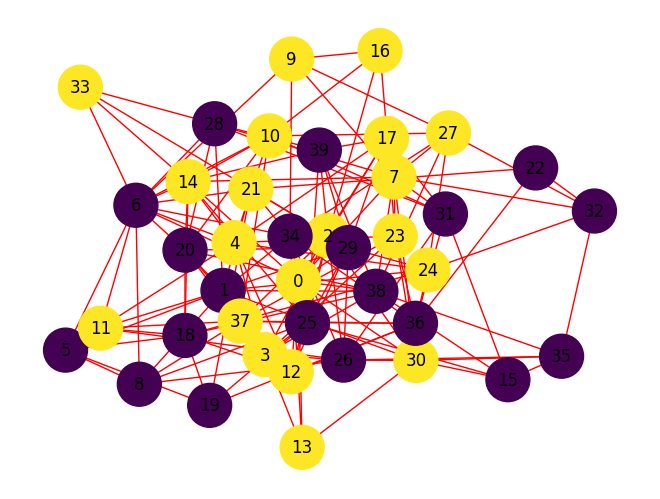

In [9]:
display(nx.draw(G,with_labels=True, 
                         node_size=1000, 
                         node_color=sample, 
                         edge_color='red'))

### Using the LeapHybridSolver

For problems of arbitrary structure and size spetially large we can use Leap Hybrid solvers. These solvers are hybrid combining classical and quantum algorithms to find optimal solutions.

[Hybrid BQM solvers](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#leaphybridsampler) accept only unconstrained objective functions. For those too any constraints must be added to the objective function, typically as a penalty. However, some Leap hybrid solvers can handle constraints natively.

In [ ]:
from dwave.system import LeapHybridSampler
from dimod import BinaryQuadraticModel

#create the BQM
bqm = BinaryQuadraticModel.from_qubo(Q)

# Run the QUBO on the solver from your config file
# set the defaults profile in the environment because europe Region doesn't have Hybrid solvers
sampler = LeapHybridSampler(profile="defaults")
answer = sampler.sample(bqm, label='Graph Partitioning -DWaveSampler')
print(answer)

In [11]:
sample = answer.record.sample[0]
print(sample)

[1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1
 1 1 1]


In [12]:
df=answer.to_pandas_dataframe()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,energy,num_occurrences
0,1,0,1,0,1,0,0,1,0,0,...,1,0,0,1,1,1,1,1,-31944.0,1


### Additional exercices


Create a larger graph and solve it with the Hybrid BQM solver.

Crearemos en esta ocasión un grafo de 70 nodos. La probabilidad de que se cree una arista concreta será del 25%.

Graph on 70 nodes created with 593 out of 2415.0 possible edges.


None

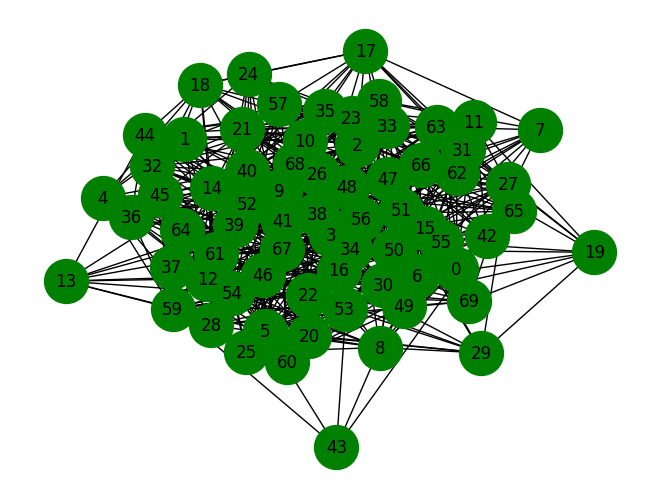

In [3]:
Graf = nx.gnp_random_graph(70, 0.25)

print("Graph on {} nodes created with {} out of {} possible edges.".format(len(Graf.nodes), len(Graf.edges), len(Graf.nodes) * (len(Graf.nodes)-1) / 2))

display(nx.draw(Graf,with_labels=True, node_size=1000, node_color='green', edge_color='black'))

Creamos la matriz $Q_2$ asociada a la función QUBO que queremos tratar.

In [4]:
# ------- Asignamos un valor de gamma -------
gamma = 80

# ------- Creación de Q2 -------

# Inicialización
Q2 = defaultdict(int)

# Rellenado
for u, v in Graf.edges:
    Q2[(u,u)] += 1
    Q2[(v,v)] += 1
    Q2[(u,v)] += -2

for i in Graf.nodes:
    Q2[(i,i)] += gamma*(1-len(Graf.nodes))

for i, j in combinations(Graf.nodes, 2):
	Q2[(i,j)] += 2*gamma

 A continuación, resolvemos el problema. Para ello, necesitamos el BQM asociado a $Q_2$.

In [5]:
# Creamos nuestro BQM a partir de Q2
bqm2 = BinaryQuadraticModel.from_qubo(Q2)

# Utilizamos el solver híbrido
sampler = LeapHybridSampler(profile="defaults")
resultado = sampler.sample(bqm2, label='Particion de grafo mayor')
print(resultado)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 69   energy num_oc.
0  0  1  0  0  1  1  0  0  0  1  1  0  1  1  1  0  0  1 ...  0 -97745.0       1
['BINARY', 1 rows, 1 samples, 70 variables]


In [6]:
# Comprobemos si la solución obtenida es válida
solucion = resultado.record.sample[0]
print(solucion)

if sum(solucion) in [math.floor(len(Graf.nodes)/2), math.ceil(len(Graf.nodes)/2)]:
    num_cut_edges = 0
    for u, v in Graf.edges:
        num_cut_edges += solucion[u] + solucion[v] - 2*solucion[u]*solucion[v]
    print("Valid partition found with", num_cut_edges, "cut edges.")
else:
    print("Invalid partition.")

[0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1
 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0]
Valid partition found with 255 cut edges.


Ya tenemos la solución. Dibujemos el grafo con la partición encontrada.

None

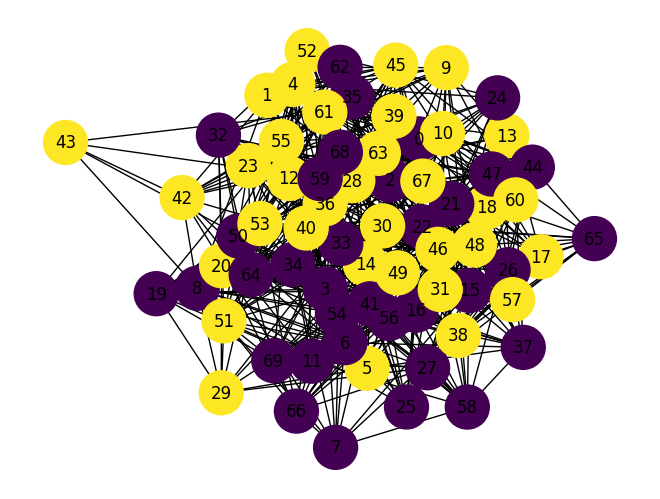

In [7]:
display(nx.draw(Graf, with_labels = True, node_size=1000, node_color=solucion))